In [1]:
!pip install transformers

In [2]:
from google.colab import drive

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity

from torch import cuda


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/preprocessed_historical_data.csv')
# dataset = dataset.sample(frac=0.2, random_state=42)

dataset

,job_id,company_name,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",Full-time,2024-04-17 23:45:08,2024-05-17 23:45:08,https://www.linkedin.com/jobs/view/921716/?trk...,Not Specified,job descriptiona leading real estate firm new ...,marketing coordinator
1,1829192,No Company Name Listed,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",Full-time,2024-04-11 17:51:27,2024-05-11 17:51:27,https://www.linkedin.com/jobs/view/1829192/?tr...,Not Specified,aspen therapy wellness committed serving clien...,mental health
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",Full-time,2024-04-16 14:26:54,2024-05-16 14:26:54,https://www.linkedin.com/jobs/view/10998357/?t...,Not Specified,national exemplar accepting application assist...,assitant restaurant manager
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",Full-time,2024-04-12 04:23:32,2024-05-12 04:23:32,https://www.linkedin.com/jobs/view/23221523/?t...,Not Specified,senior associate attorney elder law trust esta...,senior elder law trust estate associate attorney
4,35982263,No Company Name Listed,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",Full-time,2024-04-18 14:52:23,2024-05-18 14:52:23,https://www.linkedin.com/jobs/view/35982263/?t...,Not Specified,looking hvac service tech experience commerica...,service technician
...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",Full-time,2024-04-20 00:00:23,2024-05-20 00:00:23,https://www.linkedin.com/jobs/view/3906267117/...,Mid-Senior level,walnut creek office currently seeking attorney...,title attorney
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,2024-04-20 00:05:00,2024-05-20 00:17:16,https://www.linkedin.com/jobs/view/3906267126/...,Mid-Senior level,pinterest million people across world come pin...,staff software engineer ml serving platform
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,"Spokane, WA",Full-time,2024-04-20 00:07:02,2024-05-20 00:18:59,https://www.linkedin.com/jobs/view/3906267131/...,Mid-Senior level,company overview eps learning leading suppleme...,account executive
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,"Texas, United States",Full-time,2024-04-20 00:23:52,2024-05-20 00:23:52,https://www.linkedin.com/jobs/view/3906267195/...,Not Specified,business development manager carry task suppor...,business development manager


In [5]:
# Fill missing values
dataset["cleaned_title"] = dataset["cleaned_title"].fillna("")
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Combine title and description
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Ensure all values are strings
dataset["combined"] = dataset["combined"].astype(str)

# Extract text data
combined = dataset["combined"].tolist()

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: marketing coordinator job descriptiona leading real estate firm new jersey seeking administrative marketing coordinator experience graphic design working closely fun kind ambitious member sale team dynamic executive team daily basis opportunity part highly respected real estate brokerage reputation exceptional marketing extraordinary culture cooperation must creative proactive positive importantly person please responsible respectful please proficient adobe creative cloud indesign illustrator photoshop microsoft office suite fantastic taste person love working people eager office environment work directly marketing team communicate daily core staff large team agent description brief overview skill interest considered work role evolves receive organize marketing request track task communicate marketing team agent prepare print material sign open submit order printer communicate track deadlinesgraphic design managing brand strategy messaging website social medium 

In [6]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


In [7]:
labeled_postings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/500_sampled_job_postings.csv')
labeled_postings

,job_id,company_name,AI Label,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title,combined
0,3902944011,Current Power,0.0,Senior Automation Engineer - Power Systems,The Senior Automation / Power Systems Engineer...,"Houston, TX",Full-time,2024-04-16 15:01:21,2024-05-16 15:01:21,https://www.linkedin.com/jobs/view/3902944011/...,Mid-Senior level,senior automation power system engineer primar...,senior automation engineer power system,senior automation engineer power system senior...
1,3901960222,DISH Network,0.0,DISH Installation Technician - Field,"Company Summary\n\nDISH, an EchoStar Company, ...","Orange, TX",Full-time,2024-04-18 21:49:34,2024-05-18 22:02:03,https://www.linkedin.com/jobs/view/3901960222/...,Not Specified,company summary dish echostar company reimagin...,dish installation technician field,dish installation technician field company sum...
2,3900944095,"Coca-Cola Bottling Company UNITED, Inc.",0.0,Order Builder,Division: North Alabama\n\nDepartment : Oxford...,"Oxford, AL",Full-time,2024-04-17 21:06:28,2024-05-17 21:18:20,https://www.linkedin.com/jobs/view/3900944095/...,Entry level,division north alabama department oxford wareh...,order builder,order builder division north alabama departmen...
3,3903878594,Denver7 (KMGH-TV),0.0,"Mountain Multimedia Journalist, KMGH","KMGH, the E.W. Scripps Company ABC affiliate i...","Denver, CO",Full-time,2024-04-19 03:01:37,2024-05-19 03:12:28,https://www.linkedin.com/jobs/view/3903878594/...,Entry level,kmgh scripps company abc affiliate denver colo...,mountain multimedia journalist kmgh,mountain multimedia journalist kmgh kmgh scrip...
4,3905670593,BAYADA Home Health Care,0.0,Licensed Practical Nurse (LPN),"Come for the Flexibility, Stay for the Culture...","Teterboro, NJ",Full-time,2024-04-18 00:00:00,2024-05-19 09:55:42,https://www.linkedin.com/jobs/view/3905670593/...,Entry level,come flexibility stay culture needing life bal...,licensed practical nurse lpn,licensed practical nurse lpn come flexibility ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3888939625,Leidos,0.0,"Modeling, Simulation & Training AI Solution Ar...",Description\n\nLeidos is seeking a Solutions A...,"Orlando, FL",Full-time,2024-04-09 03:12:59,2024-05-09 03:28:41,https://www.linkedin.com/jobs/view/3888939625/...,Mid-Senior level,description leidos seeking solution architect ...,modeling simulation training ai solution archi...,modeling simulation training ai solution archi...
496,3904932513,Huxley,1.0,C++ Quant Dev-Trading Firm-NY/Chi/TX/Miami-150...,C++ Quantitative Trading Developer - NYC/Chi/T...,"New York, NY",Full-time,2024-04-18 14:37:47,2024-05-18 14:37:10,https://www.linkedin.com/jobs/view/3904932513/...,Mid-Senior level,quantitative trading developer 150 250 k base ...,quant,quant quantitative trading developer 150 250 k...
497,3904717528,AlixPartners,0.0,IT SharePoint Intern,"At AlixPartners, we solve the most complex and...","Detroit, MI",Full-time,2024-04-19 00:00:00,2024-05-19 22:16:21,https://www.linkedin.com/jobs/view/3904717528/...,Internship,alixpartners solve complex critical challenge ...,sharepoint intern,sharepoint intern alixpartners solve complex c...
498,3905235585,Compunnel Inc.,0.0,AS400 RPG Developer with Synon experience,Day to Day job Duties:� Convert business requi...,"Greenville, NC",Contract,2024-04-18 17:52:13,2024-05-18 17:52:13,https://www.linkedin.com/jobs/view/3905235585/...,Mid-Senior level,day day job duty convert business requirement ...,as400 rpg developer synon experience,as400 rpg developer synon experience day day j...


In [15]:
# Combine title and description into a single text field
labeled_postings["combined"] = labeled_postings["cleaned_title"].fillna("") + " " + labeled_postings["cleaned_description"].fillna("")

# Convert combined text to a list
combined_text = labeled_postings["combined"].tolist()

In [16]:
# Load pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")

# Compute embeddings for labeled postings
job_embeddings = model.encode(combined_text, show_progress_bar=True)


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [17]:
query = "ai, artificial intelligence, machine learning, deep learning, neural networks, transformers, generative ai, large language models, llm, gpt, bert, clip, t5, stable diffusion, chatbots, conversational ai, computer vision, natural language processing, nlp, speech recognition, voice recognition, multimodal ai, reinforcement learning, unsupervised learning, supervised learning, self-supervised learning, zero-shot learning, few-shot learning, transfer learning, knowledge graphs, federated learning, model optimization, gradient boosting, bayesian inference, decision trees, support vector machines, clustering, classification, regression, anomaly detection, data science, data analytics, predictive analytics, prescriptive analytics, cognitive computing, semantic search, robotics, automation, automated systems, api development, model training, model inference, model serving, mlops, autoML, distributed computing, cloud ai, edge ai, onnx, tensorflow, pytorch, jax, rapids, cuda, kubernetes, explainable ai, responsible ai, ai fairness, ai bias detection, quantum computing"

# # Add more genai and llm terms!
# query = ["Large Language Models", "Generative AI", "LLM", "Gen AI"]

# query = [
#     "Large Language Models", "LLM", "Gen AI", "Generative AI",
#     "GPT", "ChatGPT", "Transformer Models", "Foundation Models",
#     "Prompt Engineering", "Language Model Fine-tuning",
#     "Pre-trained Language Models", "AI Text Generation",
#     "Multimodal AI", "Self-supervised Learning", "Zero-shot Learning",
#     "Few-shot Learning", "AI Content Generation", "Synthetic Text Generation",
#     "AI Writing Assistants", "Conversational AI", "Autoregressive Models",
#     "BERT", "T5", "Claude AI", "Llama Models", "PaLM",
#     "Neural Text Generation", "AI-powered Chatbots", "NLP Transformers",
#     "AI Code Generation", "AI-powered Summarization", "Text-to-Image Models",
#     "AI Knowledge Distillation", "Embedding Models", "RAG (Retrieval-Augmented Generation)"
# ]

In [20]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Change if needed

# Sample AI job
ai_job = "Machine Learning Engineer - Develop AI models using deep learning"
non_ai_job = "Plumber - Repair residential water pipes and heating systems"

# Get embeddings
ai_emb = model.encode([ai_job])
non_ai_emb = model.encode([non_ai_job])
query_emb = model.encode(["artificial intelligence, machine learning, deep learning"])

# Compute similarity
sim_ai = cosine_similarity(query_emb, ai_emb)[0][0]
sim_non_ai = cosine_similarity(query_emb, non_ai_emb)[0][0]

print(f"Similarity with AI job: {sim_ai:.4f}")
print(f"Similarity with Non-AI job: {sim_non_ai:.4f}")

Similarity with AI job: 0.6118
Similarity with Non-AI job: 0.1465


In [21]:
query_embedding_labels = model.encode(query, show_progress_bar=True)

# Compute cosine similarities
cosine_similarities = cosine_similarity(job_embeddings, query_embedding_labels.reshape(1, -1)).flatten()

labeled_postings["cosine_similarity"] = cosine_similarities  # Add cosine similarities to dataframe

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

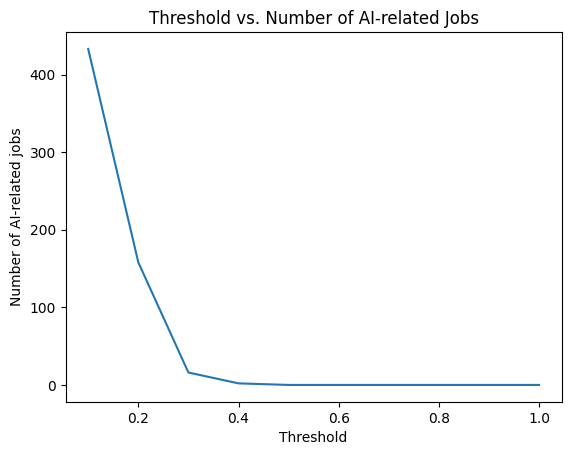

In [22]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
counts = [len(labeled_postings[cosine_similarities >= t]) for t in thresholds]

import matplotlib.pyplot as plt
plt.plot(thresholds, counts)
plt.xlabel("Threshold")
plt.ylabel("Number of AI-related jobs")
plt.title("Threshold vs. Number of AI-related Jobs")
plt.show()

In [23]:
from sklearn.metrics import precision_recall_curve, classification_report

# Define labels and predictions based on thresholds
true_labels = labeled_postings["AI Label"].fillna(0).astype(int)
thresholds = [0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33] # [round(x, 2) for x in np.arange(0.1, 1.0, 0.05)]

for threshold in thresholds:
    predictions = (labeled_postings["cosine_similarity"] >= threshold).astype(int)

    print(f"\nThreshold: {threshold}")
    print(classification_report(true_labels, predictions))


Threshold: 0.26
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       476
           1       0.44      0.75      0.55        24

    accuracy                           0.94       500
   macro avg       0.71      0.85      0.76       500
weighted avg       0.96      0.94      0.95       500


Threshold: 0.27
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       476
           1       0.50      0.75      0.60        24

    accuracy                           0.95       500
   macro avg       0.74      0.86      0.79       500
weighted avg       0.96      0.95      0.96       500


Threshold: 0.28
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       476
           1       0.57      0.71      0.63        24

    accuracy                           0.96       500
   macro avg       0.78      0.84      0.80       500
weighted avg       0.97

In [26]:
# Define a threshold for AI-related jobs
threshold = 0.3

# Filter jobs with high similarity to the AI-related query
ai_jobs = labeled_postings[cosine_similarities >= threshold]

ai_jobs


,job_id,company_name,AI Label,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title,combined,cosine_similarity
44,3904709959,AstraZeneca,1.0,"AI Engineer, Biologics Engineering, Oncology R&D",In this role you form part of a Bioinformatics...,"Gaithersburg, MD",Full-time,2024-04-19 00:00:00,2024-05-19 22:11:10,https://www.linkedin.com/jobs/view/3904709959/...,Associate,role form part bioinformatics team working cut...,ai engineer biologics engineering oncology r,ai engineer biologics engineering oncology r r...,0.315459
54,3887915892,GE HealthCare,1.0,Software Engineering Manager,Job Description Summary\n\nAs a software manag...,"Seattle, WA",Full-time,2024-04-08 00:00:00,2024-05-09 05:21:15,https://www.linkedin.com/jobs/view/3887915892/...,Mid-Senior level,job description summary software manager ge he...,software engineering manager,software engineering manager job description s...,0.337872
55,3904372360,Syniverse,1.0,Sr. Advisory Data Engineer,Syniverse is the world’s most connected compan...,United States,Full-time,2024-04-17 22:01:22,2024-05-17 22:13:21,https://www.linkedin.com/jobs/view/3904372360/...,Mid-Senior level,syniverse world connected company whether deve...,advisory data engineer,advisory data engineer syniverse world connect...,0.352235
77,3901956625,techolution,1.0,Sr Robotics Prototyping Engineer (commercial-g...,Techolution is looking for a smart and dynamic...,"Ridgewood, NJ",Internship,2024-04-18 21:34:45,2024-05-18 21:34:45,https://www.linkedin.com/jobs/view/3901956625/...,Internship,techolution looking smart dynamic sr robotics ...,sr robotics prototyping engineer robotics,sr robotics prototyping engineer robotics tech...,0.347736
79,3901170140,Info Services,1.0,Lead Data Engineer with Strong Scala (10 Years...,"Lead Data Engineer with Strong ScalaBristol, C...","Bristol, CT",Contract,2024-04-16 14:28:25,2024-05-16 14:28:24,https://www.linkedin.com/jobs/view/3901170140/...,Mid-Senior level,lead data engineer strong scalabristol ctlong ...,lead data engineer strong scala 10 year minimum,lead data engineer strong scala 10 year minimu...,0.373472
177,3887499757,Sterling Engineering,0.0,Lead Controls Engineer,Title: Automation Engineering Team LeadLocatio...,"Bolingbrook, IL",Full-time,2024-04-05 20:18:53,2024-05-05 20:18:53,https://www.linkedin.com/jobs/view/3887499757/...,Mid-Senior level,title automation engineering team leadlocation...,lead control engineer,lead control engineer title automation enginee...,0.319500
187,3901982568,ADSANTEC,1.0,Software Engineer/Sr. Software Engineer,Software Engineer/Sr. Software Engineer Locati...,"Torrance, CA",Full-time,2024-04-19 01:08:48,2024-10-16 01:08:33,https://www.linkedin.com/jobs/view/3901982568/...,Not Specified,software software engineer location torrance c...,software software engineer,software software engineer software software e...,0.306156
205,3895542330,ICE,1.0,"Developer I, Infrastructure Development & Auto...",Overview\n\nJob Purpose\n\nICE owns and operat...,"Atlanta, GA",Full-time,2024-04-12 03:03:58,2024-05-12 03:16:04,https://www.linkedin.com/jobs/view/3895542330/...,Not Specified,overview job purpose ice owns operates world a...,developer infrastructure development automation,developer infrastructure development automatio...,0.353695
227,3902840720,CentralSquare Technologies,1.0,Cloud Operations Engineer,CentralSquare is a unique enterprise software ...,United States,Full-time,2024-04-19 21:06:33,2024-05-19 21:18:29,https://www.linkedin.com/jobs/view/3902840720/...,Entry level,centralsquare unique enterprise software compa...,cloud operation engineer,cloud operation engineer centralsquare unique ...,0.307034
300,3884992276,Amazon Web Services (AWS),1.0,"Senior Partner Solutions Architect, Financial ...",Description\n\nAmazon Web Services (AWS) is lo...,"Chicago, IL",Full-time,2024-04-02 00:00:00,2024-05-06 00:14:45,https://www.linkedin.com/jobs/view

In [27]:
label_counts = ai_jobs["AI Label"].value_counts()
print(label_counts)

label_percentage = ai_jobs["AI Label"].value_counts(normalize=True) * 100
print(label_percentage)

AI Label
1.0    12
0.0     4
Name: count, dtype: int64
AI Label
1.0    75.0
0.0    25.0
Name: proportion, dtype: float64


In [28]:
# Load pre-trained embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")

# Compute embeddings for job postings
embeddings = embedding_model.encode(combined, show_progress_bar=True)

Batches:   0%|          | 0/3871 [00:00<?, ?it/s]

In [29]:
# Compute embedding for the AI-related query
query_embedding = embedding_model.encode([query], convert_to_numpy=True)

In [30]:
# Calculate cosine similarity
similarities = cosine_similarity(embeddings, query_embedding)

# Flatten similarities array
similarities = similarities.flatten()

In [31]:
dataset['similarity_score'] = similarities
dataset

,job_id,company_name,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title,combined,similarity_score
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",Full-time,2024-04-17 23:45:08,2024-05-17 23:45:08,https://www.linkedin.com/jobs/view/921716/?trk...,Not Specified,job descriptiona leading real estate firm new ...,marketing coordinator,marketing coordinator job descriptiona leading...,0.198056
1,1829192,No Company Name Listed,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",Full-time,2024-04-11 17:51:27,2024-05-11 17:51:27,https://www.linkedin.com/jobs/view/1829192/?tr...,Not Specified,aspen therapy wellness committed serving clien...,mental health,mental health aspen therapy wellness committed...,0.197007
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",Full-time,2024-04-16 14:26:54,2024-05-16 14:26:54,https://www.linkedin.com/jobs/view/10998357/?t...,Not Specified,national exemplar accepting application assist...,assitant restaurant manager,assitant restaurant manager national exemplar ...,0.107640
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",Full-time,2024-04-12 04:23:32,2024-05-12 04:23:32,https://www.linkedin.com/jobs/view/23221523/?t...,Not Specified,senior associate attorney elder law trust esta...,senior elder law trust estate associate attorney,senior elder law trust estate associate attorn...,0.159463
4,35982263,No Company Name Listed,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",Full-time,2024-04-18 14:52:23,2024-05-18 14:52:23,https://www.linkedin.com/jobs/view/35982263/?t...,Not Specified,looking hvac service tech experience commerica...,service technician,service technician looking hvac service tech e...,0.199489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,Lozano Smith,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",Full-time,2024-04-20 00:00:23,2024-05-20 00:00:23,https://www.linkedin.com/jobs/view/3906267117/...,Mid-Senior level,walnut creek office currently seeking attorney...,title attorney,title attorney walnut creek office currently s...,0.076164
123845,3906267126,Pinterest,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,2024-04-20 00:05:00,2024-05-20 00:17:16,https://www.linkedin.com/jobs/view/3906267126/...,Mid-Senior level,pinterest million people across world come pin...,staff software engineer ml serving platform,staff software engineer ml serving platform pi...,0.272238
123846,3906267131,EPS Learning,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,"Spokane, WA",Full-time,2024-04-20 00:07:02,2024-05-20 00:18:59,https://www.linkedin.com/jobs/view/3906267131/...,Mid-Senior level,company overview eps learning leading suppleme...,account executive,account executive company overview eps learnin...,0.110897
123847,3906267195,Trelleborg Applied Technologies,Business Development Manager,The Business Development Manager is a 'hunter'...,"Texas, United States",Full-time,2024-04-20 00:23:52,2024-05-20 00:23:52,https://www.linkedin.com/jobs/view/3906267195/...,Not Specified,business development manager carry task suppor...,business development manager,business development manager business developm...,0.199909


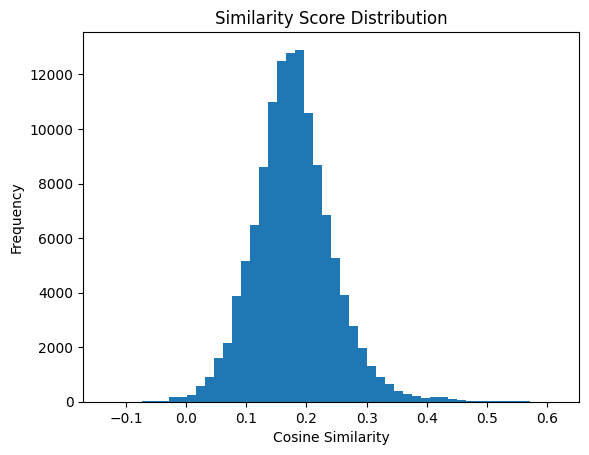

In [32]:
import matplotlib.pyplot as plt
plt.hist(similarities, bins=50)
plt.title("Similarity Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [33]:
print(similarities[:10])

[0.1980561  0.19700742 0.10764023 0.15946296 0.19948894 0.07761739
 0.22902866 0.20620225 0.1521587  0.09101702]


In [37]:
# Define a threshold for AI-related jobs
threshold = 0.31

# Filter jobs with high similarity to the AI-related query
ai_jobs = dataset[similarities >= threshold]


In [38]:
ai_jobs

,job_id,company_name,title,description,location,formatted_work_type,original_listed_time,expiry,job_posting_url,formatted_experience_level,cleaned_description,cleaned_title,combined,similarity_score
88,2747409392,ViaBot,Robot Monitor & Maintenance Technician,Robot Monitor & Maintenance TechnicianAt ViaBo...,"Sunnyvale, CA",Full-time,2024-04-09 06:01:46,2024-05-09 06:01:46,https://www.linkedin.com/jobs/view/2747409392/...,Not Specified,robot monitor maintenance technicianat viabot ...,robot monitor maintenance technician,robot monitor maintenance technician robot mon...,0.328003
116,3245063922,Saxon AI,Data Architect,Request: Data ArchitectLocation: San Francisco...,"San Francisco, CA",Contract,2024-04-19 14:27:02,2024-05-19 14:27:02,https://www.linkedin.com/jobs/view/3245063922/...,Not Specified,request data architectlocation san francisco c...,data architect,data architect request data architectlocation ...,0.318091
165,3540371917,KeyBank,Enterprise Data & Analytics Infrastructure Man...,The Enterprise Data Infrastructure and Analyti...,"Cleveland, OH",Full-time,2024-04-18 14:45:18,2024-05-18 14:45:18,https://www.linkedin.com/jobs/view/3540371917/...,Not Specified,enterprise data infrastructure analytics manag...,enterprise data analytics infrastructure manager,enterprise data analytics infrastructure manag...,0.316463
266,3728459637,HireBus,Principal Backend Engineer,Principal Backend Engineer - Join HireBus and ...,United States,Full-time,2024-04-18 20:04:36,2024-05-18 20:04:36,https://www.linkedin.com/jobs/view/3728459637/...,Not Specified,principal backend engineer join hirebus revolu...,principal backend engineer,principal backend engineer principal backend e...,0.334337
283,3742692445,ZenithMinds Inc,Sr Data Engineer with Kafka,Data Engineer with Kafka (W2 Only)💯% Remote\nM...,"Austin, TX",Full-time,2024-04-15 19:17:53,2024-10-12 19:17:15,https://www.linkedin.com/jobs/view/3742692445/...,Not Specified,data engineer kafka w2 remote min 10 strong de...,sr data engineer kafka,sr data engineer kafka data engineer kafka w2 ...,0.338215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123484,3906259167,POWER Engineers,Financial Business Intelligence Developer,We are looking for a business intelligence dev...,"Boise, ID",Full-time,2024-04-19 22:49:30,2024-05-19 23:06:47,https://www.linkedin.com/jobs/view/3906259167/...,Mid-Senior level,looking business intelligence developer join t...,financial business intelligence developer,financial business intelligence developer look...,0.311930
123580,3906259593,No Company Name Listed,Data Engineering Lead,Role Title: Data Engineering Lead for a global...,"New York, NY",Full-time,2024-04-19 23:21:35,2024-05-19 23:21:35,https://www.linkedin.com/jobs/view/3906259593/...,Mid-Senior level,role title data engineering lead global law fi...,data engineering lead,data engineering lead role title data engineer...,0.322347
123696,3906260990,Femtotest,Senior ATE Test engineer,Looking for a Senior ATE Test engineer (not a ...,"Watsonville, CA",Full-time,2024-04-20 00:18:39,2024-10-17 00:17:54,https://www.linkedin.com/jobs/view/3906260990/...,Not Specified,looking senior ate test engineer software test...,senior ate test engineer,senior ate test engineer looking senior ate te...,0.315162
123707,3906261067,Qualcomm,"Technical Account Manager, Senior Staff Engineer","Company\n\nQualcomm Technologies, Inc.\n\nJob ...","Detroit, MI",Full-time,2024-04-19 22:59:06,2024-05-19 23:15:56,https://www.linkedin.com/jobs/view/3906261067/...,Not Specified,company qualcomm technology job area engineeri...,technical account manager senior staff engineer,technical account manager senior staff enginee...,0.311241


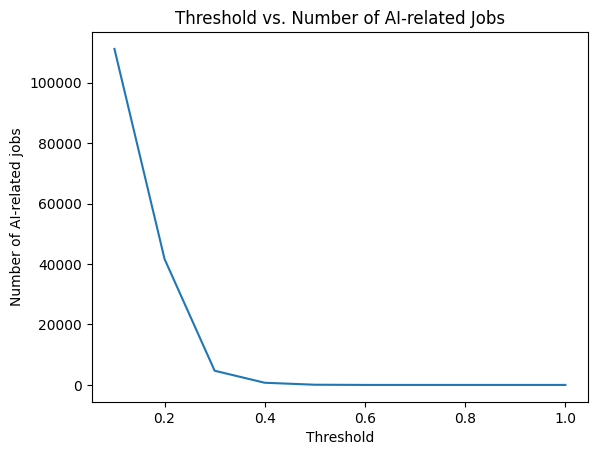

In [39]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
counts = [len(dataset[similarities >= t]) for t in thresholds]

import matplotlib.pyplot as plt
plt.plot(thresholds, counts)
plt.xlabel("Threshold")
plt.ylabel("Number of AI-related jobs")
plt.title("Threshold vs. Number of AI-related Jobs")
plt.show()

In [40]:
ai_jobs.to_csv('/content/drive/My Drive/Colab Notebooks/Comparing Transformer models/ai_jobs_allmini_031.csv', index=False)